# COMP8240 - Assessment 2
## Name : Phan Vinh Phu
## StudentID : 45747989

### Set Up Dependencies

In [1]:
# !pip install vaderSentiment
# !pip install --upgrade vaderSentiment

### Import libraries

In [2]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import nltk
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import math

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\VinhPhu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Task 1 : Read the important features of the tweets of Kevin Rudd and Scott Morrison into a single Pandas dataframe

In [3]:
def extract_json(file_name):
    with open(file_name, encoding='utf-8', mode='r') as file:  
        output = []
        list_of_dicts = json.load(file)
        for tweet_dict in list_of_dicts:
            media = tweet_dict['entities'].get('media', [])
            output.append({
                'user': str(tweet_dict['user']["name"]),
                'created_at': tweet_dict['created_at'],
                'text': str(tweet_dict['full_text']),
                'hashtags': tweet_dict['entities']["hashtags"],
                'link': tweet_dict['entities']["urls"],
                "media": media
            })
    return output

Kevin_Rudd = extract_json("./tweets/kevin.json")
Scott_Morrison = extract_json("./tweets/scott.json")

In [4]:
Kevin_Rudd_df = pd.DataFrame(Kevin_Rudd, columns = ['user', 'created_at', 'text','hashtags', 'link', 'media'])
Scott_Morrison_df = pd.DataFrame(Scott_Morrison, columns = ['user', 'created_at', 'text','hashtags', 'link', 'media'])
# Merge the two lists into a single dataframe
df = pd.concat([Kevin_Rudd_df, Scott_Morrison_df])

# Convert the "created_at" column to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df.head()

,user,created_at,text,hashtags,link,media
0,Kevin Rudd,2021-10-05 07:40:53+00:00,Is this incompetence or corruption?! Frydenber...,[],"[{'url': 'https://t.co/QLUPCQCQtz', 'expanded_...",[]
1,Kevin Rudd,2021-10-05 05:42:08+00:00,Murdoch's global empire has been promoting the...,"[{'text': 'MurdochRoyalCommission', 'indices':...","[{'url': 'https://t.co/3ZKpxswe3U', 'expanded_...",[]
2,Kevin Rudd,2021-10-04 01:49:12+00:00,How strange to see Alexander Downer—in an arti...,[],"[{'url': 'https://t.co/IjifnrtJvy', 'expanded_...",[]
3,Kevin Rudd,2021-10-03 11:01:32+00:00,Murdoch’s Credlin rewriting the history of COV...,[],[],"[{'id': 1444618612531027971, 'id_str': '144461..."
4,Kevin Rudd,2021-10-03 09:18:41+00:00,Great that Qld is hosting the Grand Final. I’v...,[],"[{'url': 'https://t.co/46zXioFESP', 'expanded_...",[]


### Task 2 : Plot the posting times of the tweets for the two users in one bar chart

### Extract the hour from the "created_at" column and create a new column for it

In [5]:
df['hour'] = df['created_at'].dt.hour

### Create a bar chart to visualize the tweet counts at each hour

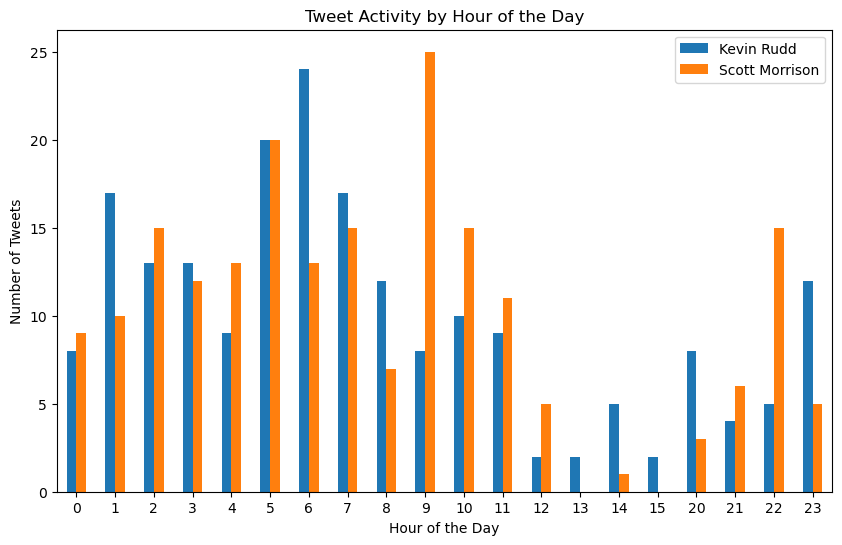

In [6]:
# Group by both user and hour and plot the bar chart
hourly_tweet_counts = df.groupby(["hour", "user"]).size().unstack(level=1)
hourly_tweet_counts.plot(kind='bar', figsize=(10, 6))

# Customize the chart
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Tweets')
plt.title('Tweet Activity by Hour of the Day')
plt.legend()
plt.xticks(rotation=0)

plt.show()

### Task 3 : Construct one bar chart of the proportions of tweets for each of the two users that contain pictures or links.

### The proportions for Kevin Rudd

In [7]:
# Filter for rows where 'user' is equal to 'Kevin Rudd' and either 'link' or 'media' is not an empty list
filtered_Rudd = df[(df['user'] == 'Kevin Rudd') & ((df['link'].apply(len) > 0) | (df['media'].apply(len) > 0))]

# Calculate the proportion of tweets with pictures or links for Kevin Rudd
proportion_Rudd = (filtered_Rudd.shape[0] / df[df['user'] == 'Kevin Rudd'].shape[0]) * 100

### The proportions for Scott Morrison

In [8]:
# Filter for rows where 'user' is equal to 'Kevin Rudd' and either 'link' or 'media' is not null
filtered_Morrison = df[(df['user'] == 'Scott Morrison')  &  ((df['link'].apply(len) > 0) | (df['media'].apply(len) > 0))]

# Count the number of rows in the filtered DataFrame
proportion_Morrison = (filtered_Morrison.shape[0]/df[df['user'] == 'Scott Morrison'].shape[0]) * 100

### Create a bar chart of the proportions

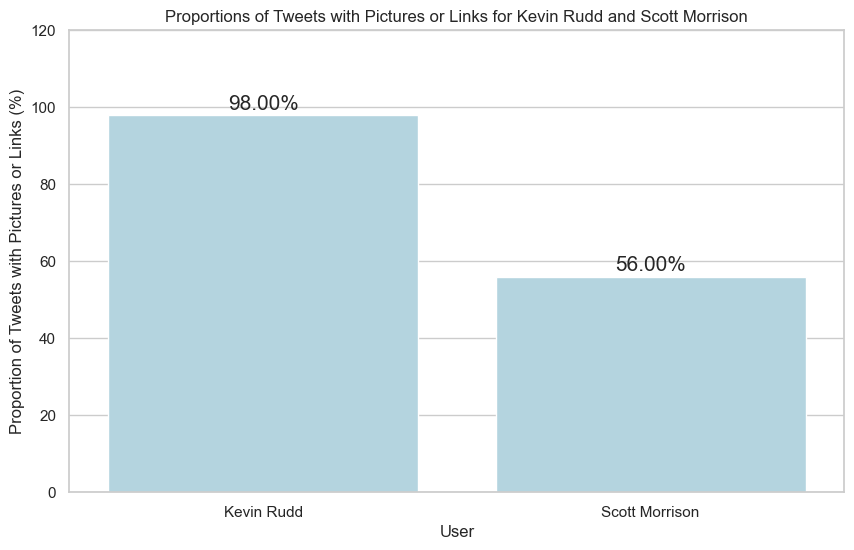

In [9]:
# Create a bar chart of the proportions using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=['Kevin Rudd', 'Scott Morrison'], y=[proportion_Rudd, proportion_Morrison], palette=['lightblue', 'lightblue'])
ax.set_ylim([0, 120])

# Annotate the bars with percentage values
for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.2f}%', 
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                ha='center', va='center', size=15, xytext=(0, 8), textcoords='offset points')

plt.xlabel('User')
plt.ylabel('Proportion of Tweets with Pictures or Links (%)')
plt.title('Proportions of Tweets with Pictures or Links for Kevin Rudd and Scott Morrison')

plt.show()

### Task 4 : Construct a histogram of the number of hashtags in tweets for each of the two users.

### Calculate the number of hashtags for each tweet

In [10]:
df["num_of_hashtags"] = df["hashtags"].apply(len)

# Create a separate DataFrame for each user
kevin_rudd_df = df[df['user'] == 'Kevin Rudd']
scott_morrison_df = df[df['user'] == 'Scott Morrison']

### Create histograms for the number of hashtags in tweets for each of two users

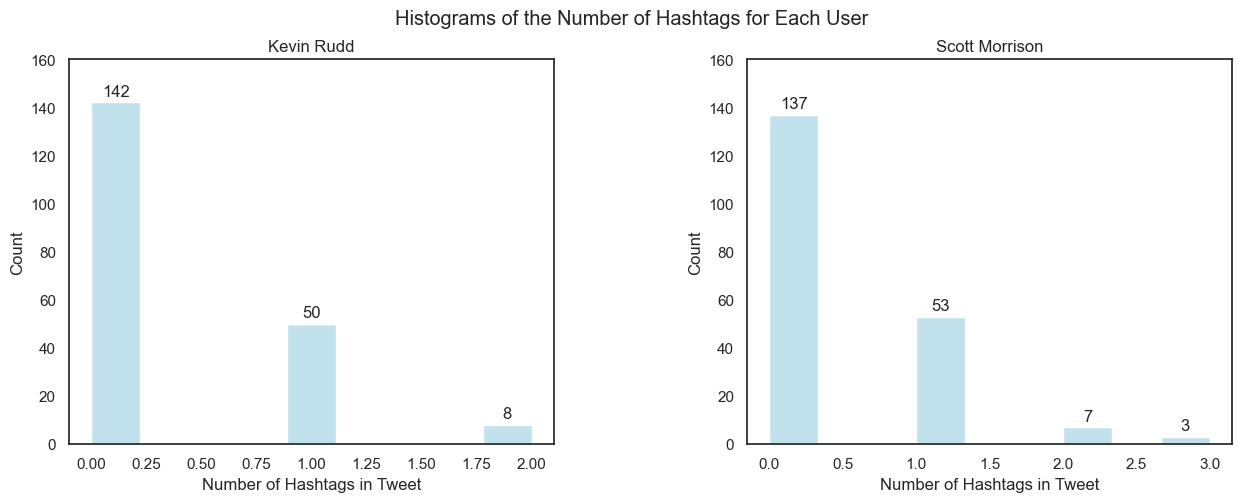

In [11]:
# Set the style
sns.set(style="white")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4)
fig.suptitle('Histograms of the Number of Hashtags for Each User')

# Left figure: Kevin Rudd
axes[0].set_title('Kevin Rudd')
axes[0].set_xlabel("Number of Hashtags in Tweet")
sns.histplot(data=kevin_rudd_df, x="num_of_hashtags", ax=axes[0], color="lightblue")
axes[0].set_ylim([0, 160])
for bar in axes[0].patches:
    if bar.get_height() > 0:
        axes[0].annotate(bar.get_height(),
                        (bar.get_x() + bar.get_width() / 2, 
                         bar.get_height()), ha='center', va='center',
                         size=12, xytext=(0, 8),
                         textcoords='offset points')
            
# Right figure: Scott Morrison
axes[1].set_title('Scott Morrison')
axes[1].set_xlabel("Number of Hashtags in Tweet")
sns.histplot(data=scott_morrison_df, x="num_of_hashtags", ax=axes[1],color="lightblue")
for bar in axes[1].patches:
    if bar.get_height() > 0:
        axes[1].annotate(bar.get_height(),(bar.get_x() + bar.get_width() / 2, 
                         bar.get_height()), ha='center', va='center',
                         size=12, xytext=(0, 8),
                         textcoords='offset points')
axes[1].set_ylim([0, 160])

plt.show()

### Task 5 : Calculate the log odds ratio (check here for an example) for each word used in the set of tweets, and list the 20 words most strongly associated with each of the two users.

### Define functions to clean tweets

In [12]:
def clean_and_tokenize(tweet):
    # Remove URLs and non-alphabetical characters, convert to lowercase
    tweet = re.sub(r'https?:\/\/\S*|www.\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub("'", "", tweet)
    tweet = re.sub('rt', '', tweet)
    tweet = re.sub('[^a-zA-Z0-9]', ' ', tweet).lower()
    

    # Tokenize the tweet text
    words = word_tokenize(tweet)

    # Remove stopwords
    words = [word for word in words if word not in stopwords.words("english")]
    
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return words

def clean_full_text_tweets(df):
    tweet_corpus = []
    for i in range(len(df.index)):
        cleaned_words = clean_and_tokenize(df['text'][i])
        for word in cleaned_words:
            if word not in ["u", "rt"] and not word.isdigit():
                tweet_corpus.append(word)

    return tweet_corpus

In [13]:
kevin_rudd_corpus = clean_full_text_tweets(kevin_rudd_df)
scott_morrison_corpus = clean_full_text_tweets(scott_morrison_df)

In [14]:
print(kevin_rudd_corpus)

['incompetence', 'corruption', 'frydenberg', 'warned', 'company', 'appeared', 'altering', 'revenue', 'data', 'receive', 'jobkeeper', 'nothing', 'economic', 'illiterate', 'rubbished', 'govt', 'world', 'leading', 'response', 'gfc', 'murdoch', 'global', 'empire', 'promoting', 'conspiracy', 'theory', 'australian', 'held', 'hostage', 'tyrannical', 'government', 'pa', 'new', 'world', 'order', 'wonder', 'american', 'think', 'need', 'saved', 'murdochroyalcommission', 'strange', 'see', 'alexander', 'downer', 'aicle', 'downplaying', 'rise', 'china', 'cited', 'ex', 'foreign', 'minister', 'amp', 'ex', 'high', 'commissioner', 'downer', 'think', 'forgotten', 'fully', 'paid', 'director', 'huawei', 'australia', 'board', 'director', 'murdoch', 'credlin', 'rewriting', 'history', 'covid', 'attack', 'victoria', 'praising', 'berejiklian', 'forget', 'month', 'tragedy', 'nsw', 'came', 'refused', 'lock', 'delta', 'spread', 'vic', 'great', 'qld', 'hosting', 'grand', 'final', 'always', 'wayne', 'bennett', 'fan'

### Count the occurence to calculate log odds ratio for each word

In [15]:
def occurence_wordcount(corpus):
    output = {}
    for word in corpus:
        if word not in output.keys():
            output[word] = 1
        else:
            output[word] += 1
    return output

def log_odds_ratio(corpus) :
    word_count_dict = occurence_wordcount(corpus)
    total_number = sum(word_count_dict.values())
    output = {}
    
    for word, count in word_count_dict.items():
        output[word] = math.log((count + 1) / (total_number + 1))
    
    return output

In [16]:
# Calculate log odds ratios for each user's corpus
log_odds_kevin_rudd = log_odds_ratio(kevin_rudd_corpus)
log_odds_scott_morrison = log_odds_ratio(scott_morrison_corpus)

In [17]:
log_odds_kevin_rudd

{'incompetence': -6.320093606268169,
 'corruption': -7.70638796738806,
 'frydenberg': -7.70638796738806,
 'warned': -7.300922859279895,
 'company': -6.60777567871995,
 'appeared': -7.70638796738806,
 'altering': -7.70638796738806,
 'revenue': -7.70638796738806,
 'data': -7.70638796738806,
 'receive': -7.300922859279895,
 'jobkeeper': -7.013240786828114,
 'nothing': -7.013240786828114,
 'economic': -7.300922859279895,
 'illiterate': -7.70638796738806,
 'rubbished': -7.70638796738806,
 'govt': -6.096950054953959,
 'world': -6.0016398751496345,
 'leading': -7.013240786828114,
 'response': -7.013240786828114,
 'gfc': -7.300922859279895,
 'murdoch': -3.3756546271017287,
 'global': -6.453624998892692,
 'empire': -6.790097235513905,
 'promoting': -7.013240786828114,
 'conspiracy': -6.0016398751496345,
 'theory': -6.320093606268169,
 'australian': -5.455096168781565,
 'held': -7.300922859279895,
 'hostage': -7.70638796738806,
 'tyrannical': -7.70638796738806,
 'government': -6.096950054953959,

In [18]:
log_odds_scott_morrison

{'warm': -6.4853983032037545,
 'congrats': -6.667719859997709,
 'japanese': -7.1785454837637,
 'pm': -5.058281947563609,
 'kishida': -7.5840105918718645,
 'great': -4.780650210965329,
 'chat': -6.4853983032037545,
 'special': -7.1785454837637,
 'strategic': -6.4853983032037545,
 'panership': -5.443944428375594,
 'effos': -6.667719859997709,
 'secure': -5.879262499633439,
 'prosperous': -6.890863411311919,
 'indo': -5.3867860145356445,
 'pacific': -5.099103942083864,
 'well': -6.07993319509559,
 'strengthen': -6.3312476233764965,
 'defence': -6.4853983032037545,
 'security': -6.07993319509559,
 'amp': -4.0144778953904945,
 'economic': -5.974572679437764,
 'tie': -5.974572679437764,
 'incl': -6.890863411311919,
 'supply': -6.890863411311919,
 'chain': -7.5840105918718645,
 'clean': -7.5840105918718645,
 'energy': -6.667719859997709,
 'working': -5.792251122643809,
 'paners': -6.4853983032037545,
 'quad': -6.3312476233764965,
 'australia': -3.78852140269967,
 'india': -6.07993319509559,
 

### Top 20 words with the highest log odds ratio for Kevin Rudd and Scott Morrison

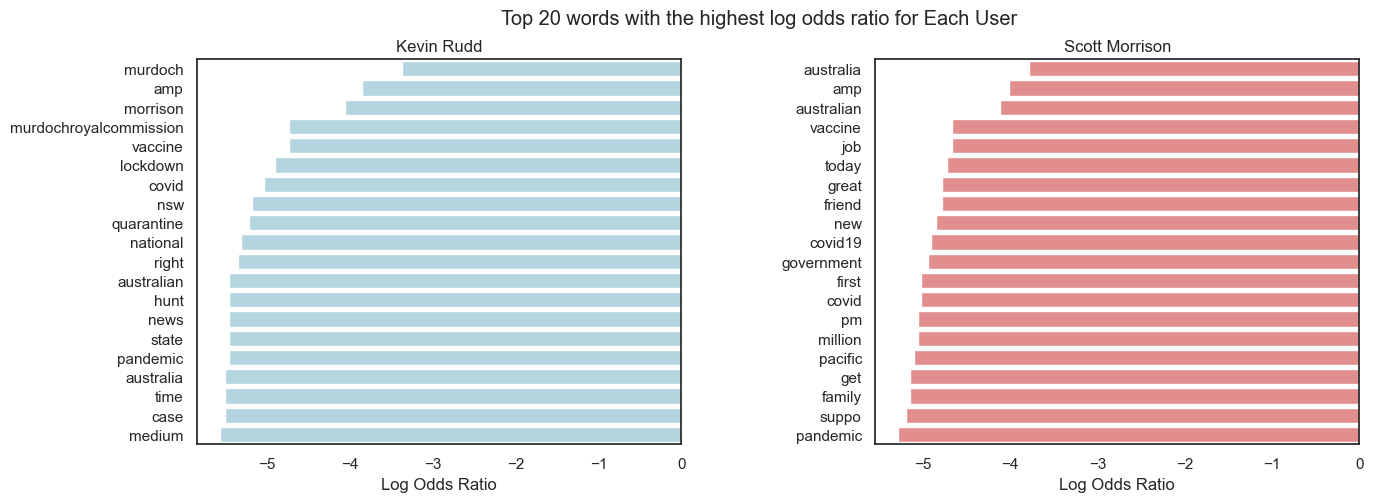

In [19]:
# Sort the words by log odds ratio in descending order
sorted_kevin_rudd = dict(sorted(log_odds_kevin_rudd.items(), key=lambda x: x[1], reverse=True))
sorted_scott_morrison = dict(sorted(log_odds_scott_morrison.items(), key=lambda x: x[1], reverse=True))

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4)
fig.suptitle('Top 20 words with the highest log odds ratio for Each User')

# Left figure: Kevin Rudd
sns.barplot(x=list(sorted_kevin_rudd.values())[:20], y=list(sorted_kevin_rudd.keys())[:20], orient="h", color="lightblue", ax=axes[0])
axes[0].set_title('Kevin Rudd')
axes[0].set_xlabel("Log Odds Ratio")

# Right figure: Scott Morrison
sns.barplot(x=list(sorted_scott_morrison.values())[:20], y=list(sorted_scott_morrison.keys())[:20], orient="h", color="lightcoral", ax=axes[1])
axes[1].set_title('Scott Morrison')
axes[1].set_xlabel("Log Odds Ratio")

plt.show()

### Task 6 : Use the vaderSentiment module to calculate the sentiment of each tweet, and then for each of the two users, calculate the average 'compound' sentiment for all their tweets.

###  Calculate the sentiment of each tweet

In [20]:
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate compound sentiment
def calculate_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

# Add a new column to the DataFrame with the 'compound' sentiment scores
df['compound_sentiment'] = df['text'].apply(calculate_sentiment)

In [22]:
df.head()

,user,created_at,text,hashtags,link,media,hour,num_of_hashtags,compound_sentiment
0,Kevin Rudd,2021-10-05 07:40:53+00:00,Is this incompetence or corruption?! Frydenber...,[],"[{'url': 'https://t.co/QLUPCQCQtz', 'expanded_...",[],7,0,-0.4574
1,Kevin Rudd,2021-10-05 05:42:08+00:00,Murdoch's global empire has been promoting the...,"[{'text': 'MurdochRoyalCommission', 'indices':...","[{'url': 'https://t.co/3ZKpxswe3U', 'expanded_...",[],5,1,-0.0772
2,Kevin Rudd,2021-10-04 01:49:12+00:00,How strange to see Alexander Downer—in an arti...,[],"[{'url': 'https://t.co/IjifnrtJvy', 'expanded_...",[],1,0,-0.4019
3,Kevin Rudd,2021-10-03 11:01:32+00:00,Murdoch’s Credlin rewriting the history of COV...,[],[],"[{'id': 1444618612531027971, 'id_str': '144461...",11,0,-0.7964
4,Kevin Rudd,2021-10-03 09:18:41+00:00,Great that Qld is hosting the Grand Final. I’v...,[],"[{'url': 'https://t.co/46zXioFESP', 'expanded_...",[],9,0,0.2244


### Calculate the average 'compound' sentiment for each of the two users

In [23]:
KR_average_sentiment = df[df['user'] == 'Kevin Rudd']['compound_sentiment'].mean()
SM_average_sentiment = df[df['user'] == 'Scott Morrison']['compound_sentiment'].mean()

In [25]:
print(f"The average 'compound' sentiment for Kevin Rudd's tweets is {round(KR_average_sentiment, 3)}")
print(f"The average 'compound' sentiment for Scott Morrison's tweets is {round(SM_average_sentiment, 3)}")

The average 'compound' sentiment for Kevin Rudd's tweets is -0.185
The average 'compound' sentiment for Scott Morrison's tweets is 0.471


### Plot the proportion of tweets' compound sentiment

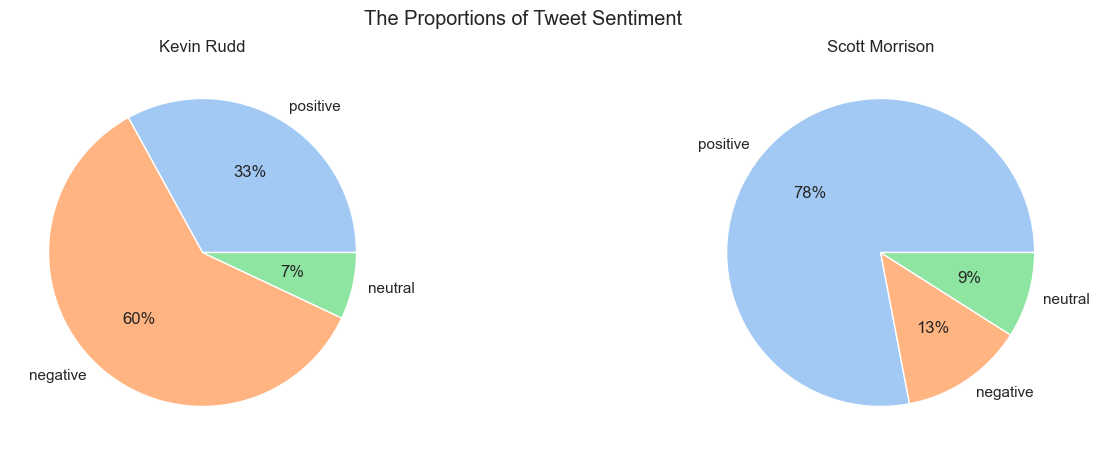

In [29]:
def cal_sentiment_proportion(df):
    positive = 0
    negative = 0
    neutral = 0
    for i in range(0, len(df.index)):
        if df['compound_sentiment'].iloc[i] > 0:
            positive += 1
        elif df['compound_sentiment'].iloc[i] < 0:
            negative += 1
        else:
            neutral += 1
    return {'positive': positive, 'negative': negative, 'neutral': neutral}

KR_sentiment_proportion = cal_sentiment_proportion(df[df['user'] == 'Kevin Rudd'])
SM_sentiment_proportion = cal_sentiment_proportion(df[df['user'] == 'Scott Morrison'])

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4)
fig.suptitle('The Proportions of Tweet Sentiment')
palette_color = sns.color_palette('pastel')

# Left figure: Kevin Rudd
KR_keys = KR_sentiment_proportion.keys()
KR_values = KR_sentiment_proportion.values()
axes[0].pie(KR_values, labels=KR_keys, colors=palette_color, autopct='%.0f%%') 
axes[0].set_title('Kevin Rudd')

# Right figure: Scott Morrison
SM_keys = SM_sentiment_proportion.keys()
SM_values = SM_sentiment_proportion.values()
axes[1].pie(SM_values, labels=SM_keys, colors=palette_color, autopct='%.0f%%') 
axes[1].set_title('Scott Morrison')

plt.show()